Download the needed datasets

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip train2017.zip
!unzip val2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

Import needed libraries

In [ ]:
import os
import numpy as np
import random

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

from PIL import Image

from skimage import color
from skimage.metrics import structural_similarity as ssim

Load the COCO datasets. Reshape to use LAB color codes: L axis in input data, A and B is output. Split train-test data here

In [ ]:
class CocoColorizationDataset(Dataset):
    def __init__(self, image_dir, image_size=256):
        self.image_paths = [
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if f.lower().endswith((".jpg", ".png"))
        ]
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = self.transform(img)
        img = np.asarray(img) / 255.0

        lab = color.rgb2lab(img).astype(np.float32)
        L = lab[:, :, 0] / 100.0
        ab = lab[:, :, 1:] / 128.0

        L = torch.from_numpy(L).unsqueeze(0)           # (1, H, W)
        ab = torch.from_numpy(ab).permute(2, 0, 1)     # (2, H, W)
        return L, ab

def build_dataloaders(train_dir, val_dir, batch_size=16, num_workers=4):
    train_dataset = CocoColorizationDataset(train_dir)
    val_dataset = CocoColorizationDataset(val_dir)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader

# File path
train_dir = "/content/train2017"
val_dir = "/content/val2017"

train_loader, val_loader = build_dataloaders(train_dir, val_dir, batch_size=32)

Set up the pretrained Resnet-34 model. Set up the ColorizationUNet decoder.

In [ ]:
# PART 2: Set up a pretrained Resnet-34 model
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        resnet = models.resnet34(pretrained=pretrained)
        self.initial = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        self.layer1 = resnet.layer1  # 64
        self.layer2 = resnet.layer2  # 128
        self.layer3 = resnet.layer3  # 256
        self.layer4 = resnet.layer4  # 512

    def forward(self, x):
        x0 = self.initial(x)   # 64, H/4, W/4
        x1 = self.layer1(x0)   # 64, H/4, W/4
        x2 = self.layer2(x1)   # 128, H/8, W/8
        x3 = self.layer3(x2)   # 256, H/16, W/16
        x4 = self.layer4(x3)   # 512, H/32, W/32
        return x1, x2, x3, x4

# Decoder
class ColorizationUNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)

        self.up4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(65, 64, 3, padding=1),  # 64 + 1 = 65
            nn.ReLU(inplace=True)
        )

        self.out_conv = nn.Conv2d(64, 2, 1)

    def forward(self, L):
        # replicate L to 3 channels for ResNet
        x = L.repeat(1, 3, 1, 1)

        x1, x2, x3, x4 = self.encoder(x)

        d4 = self.up4(x4)
        d4 = F.interpolate(d4, size=x3.shape[2:], mode='bilinear', align_corners=False)
        d4 = self.conv4(torch.cat([d4, x3], dim=1))

        d3 = self.up3(d4)
        d3 = F.interpolate(d3, size=x2.shape[2:], mode='bilinear', align_corners=False)
        d3 = self.conv3(torch.cat([d3, x2], dim=1))

        d2 = self.up2(d3)
        d2 = F.interpolate(d2, size=x1.shape[2:], mode='bilinear', align_corners=False)
        d2 = self.conv2(torch.cat([d2, x1], dim=1))

        d1 = self.up1(d2)
        d1 = F.interpolate(d1, size=L.shape[2:], mode='bilinear', align_corners=False)
        d1 = self.conv1(torch.cat([d1, L], dim=1))
        # final skip from L input

        ab_out = torch.tanh(self.out_conv(d1))  # output ab ∈ [-1,1]
        return ab_out

# Model setup
model = ColorizationUNet(pretrained=True)
L = torch.randn(2, 1, 256, 256)
ab = model(L)

Set up the PatchGAN network as a discriminator. This will be used as a model determining the real vs. fake image.

In [ ]:
# PART 3: Set up a PatchGAN network as a discriminator (real vs. fake).
class PatchGANDiscriminator(nn.Module):
  def __init__(self, in_channels = 5):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels, 64, kernel_size = 4, stride = 2, padding = 1) # (B, 64, H/2, W/2)
    self.conv2 = nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1)         # (B, 128, H/4, W/4)
    self.conv3 = nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1)        # (B, 256, H/8, W/8)
    self.conv4 = nn.Conv2d(256, 512, kernel_size = 4, stride =2, padding = 1)         # (B, 512, H/16, W/16)
    self.conv5 = nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 1)          # (B, 1, H/16, W/16)

    self.leaky_relu = nn.LeakyReLU(0.2, inplace = True)

  def forward(self, x):
    x = self.leaky_relu(self.conv1(x))
    x = self.leaky_relu(self.conv2(x))
    x = self.leaky_relu(self.conv3(x))
    x = self.leaky_relu(self.conv4(x))
    x = torch.sigmoid(self.conv5(x))
    return x

Build the SSIM metric calculator and model evaluator. Used for model optimization and final result analysis.

In [ ]:
# SSIM metric calculator

def calculate_ssim(ab_pred, ab_real):
    """Calculate SSIM for colorized images"""
    batch_size = ab_pred.size(0)
    ssim_scores = []

    for i in range(batch_size):
        pred = ab_pred[i].detach().cpu().numpy().transpose(1, 2, 0)
        real = ab_real[i].detach().cpu().numpy().transpose(1, 2, 0)

        # Calculate SSIM for each channel and average
        ssim_a = ssim(pred[:, :, 0], real[:, :, 0], data_range=2.0)
        ssim_b = ssim(pred[:, :, 1], real[:, :, 1], data_range=2.0)
        ssim_scores.append((ssim_a + ssim_b) / 2)

    return np.mean(ssim_scores)

def evaluate_model(model, val_loader, device):
    """Evaluate model on validation set"""
    model.eval()
    val_ssim_scores = []
    val_l1_losses = []

    with torch.no_grad():
        for L_val, ab_val in val_loader:
            L_val, ab_val = L_val.to(device), ab_val.to(device)
            ab_pred = model(L_val)

            val_l1 = criterion_L1(ab_pred, ab_val).item()
            val_ssim = calculate_ssim(ab_pred, ab_val)

            val_l1_losses.append(val_l1)
            val_ssim_scores.append(val_ssim)

    avg_val_l1 = np.mean(val_l1_losses)
    avg_val_ssim = np.mean(val_ssim_scores)

    print(f"Validation Results - L1 Loss: {avg_val_l1:.4f}, SSIM: {avg_val_ssim:.4f}")
    return avg_val_l1, avg_val_ssim

Train the model. Implements a weighted sum of L1 loss, adversarial loss, and SSIM loss.

In [ ]:
# Define device (Check if GPU is available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model.to(device)

# Instantiate the PathGAN discriminator model
patchgan_discriminator = PatchGANDiscriminator(in_channels = 5).to(device)

# Loss functions
criterion_L1 = nn.L1Loss()
criterion_GAN = nn.BCELoss()

# Optimizers
generator_optimizer = optim.Adam(model.parameters(), lr = 0.0002, betas = (0.5, 0.999))
discriminator_optimizer = optim.Adam(patchgan_discriminator.parameters(), lr = 0.0002, betas = (0.5, 0.999))

# TensorBoard setup
writer = SummaryWriter('runs/colorization_gan')

# Create a Subset of the dataset
subset_size = int(len(train_loader.dataset) * 0.1)
subset_indices = random.sample(range(len(train_loader.dataset)), subset_size)
train_subset = Subset(train_loader.dataset, subset_indices)
train_loader_subset = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

# Training Loop (Updated)
num_epochs = 10
best_val_ssim = float('-inf')  # To keep track of the best SSIM

for epoch in range(1, num_epochs + 1):
    model.train
    for i, (L, ab_real) in enumerate(train_loader_subset):
        L, ab_real = L.to(device), ab_real.to(device)

        # Train discriminator
        patchgan_discriminator.zero_grad()

        real_images = torch.cat((L.repeat(1, 3, 1, 1), ab_real), dim=1)
        output_real = patchgan_discriminator(real_images)
        real_labels = torch.ones_like(output_real, device=device)
        d_loss_real = criterion_GAN(output_real, real_labels)

        ab_fake = model(L)
        fake_images = torch.cat((L.repeat(1, 3, 1, 1), ab_fake), dim=1)
        output_fake = patchgan_discriminator(fake_images.detach())  # Detach to avoid backprop in generator
        fake_labels = torch.zeros_like(output_fake, device=device)
        d_loss_fake = criterion_GAN(output_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        discriminator_optimizer.step()

        # Train generator
        model.zero_grad()
        ab_fake = model(L)  # Generate fake ab
        fake_images = torch.cat((L.repeat(1, 3, 1, 1), ab_fake), dim=1)
        output_fake = patchgan_discriminator(fake_images)
        g_loss_gan = criterion_GAN(output_fake, real_labels)

        g_loss_pixel = criterion_L1(ab_fake, ab_real)
        g_loss = g_loss_gan + 75 * g_loss_pixel + 50 * (1 - calculate_ssim(ab_fake, ab_real))
        g_loss.backward()
        generator_optimizer.step()

        # Log training progress
        if i % 100 == 0 or i == len(train_loader_subset)-1:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i + 1}/{len(train_loader_subset)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

        # TensorBoard logging
        writer.add_scalar("Loss/Discriminator", d_loss.item(), epoch * len(train_loader_subset) + i)
        writer.add_scalar("Loss/Generator", g_loss.item(), epoch * len(train_loader_subset) + i)

        if i % 500 == 0 or (i == len(train_loader_subset) - 1):
            # Reconstruct RGB images from L and predicted ab for TensorBoard
            batch_rgb_images = []
            for j in range(min(4, L.shape[0])): # Log up to 4 images
                L_img = L[j].cpu().numpy()[0] * 100.0  # Scale L to 0-100
                ab_img = ab_fake[j].detach().cpu().numpy().transpose(1, 2, 0) * 128.0 # Scale ab to -128-127 and transpose to HWC

                lab_img = np.concatenate([L_img[:, :, np.newaxis], ab_img], axis=2) # Combine to LAB (H, W, 3)
                rgb_img = color.lab2rgb(lab_img) # Convert to RGB (H, W, 3), values 0-1

                # Convert to Tensor and permute to CHW for TensorBoard
                rgb_tensor = torch.from_numpy(rgb_img).permute(2, 0, 1).float()
                batch_rgb_images.append(rgb_tensor)

            # Stack individual images into a batch tensor
            if batch_rgb_images:
                tb_images = torch.stack(batch_rgb_images)
                writer.add_images("Generated_Images", tb_images, epoch * len(train_loader_subset) + i)
    avg_val_l1, avg_val_ssim = evaluate_model(model, val_loader, device)

    # Save the best model based on SSIM
    if avg_val_ssim > best_val_ssim:
        best_val_ssim = avg_val_ssim
        torch.save(model.state_dict(), f"best_colorization_unet.pth")
        torch.save(patchgan_discriminator.state_dict(), f"best_patchgan_discriminator.pth")

    # Save the models after every epoch
    torch.save(model.state_dict(), f"colorization_unet_epoch_{epoch}.pth")
    torch.save(patchgan_discriminator.state_dict(), f"patchgan_discriminator_epoch_{epoch}.pth")

Epoch [1/10], Step [1/370], D Loss: 1.3866, G Loss: 65.3251
Epoch [1/10], Step [101/370], D Loss: 1.2651, G Loss: 34.8981
Epoch [1/10], Step [201/370], D Loss: 1.0297, G Loss: 33.6157
Epoch [1/10], Step [301/370], D Loss: 1.4205, G Loss: 36.9951
Epoch [1/10], Step [370/370], D Loss: 0.9366, G Loss: 35.9199
Validation Results - L1 Loss: 0.0690, SSIM: 0.4036
Epoch [2/10], Step [1/370], D Loss: 1.2870, G Loss: 35.0009
Epoch [2/10], Step [101/370], D Loss: 0.5354, G Loss: 44.4805
Epoch [2/10], Step [201/370], D Loss: 0.8046, G Loss: 36.1892
Epoch [2/10], Step [301/370], D Loss: 1.4173, G Loss: 40.5163
Epoch [2/10], Step [370/370], D Loss: 0.9986, G Loss: 42.5883
Validation Results - L1 Loss: 0.0718, SSIM: 0.3767
Epoch [3/10], Step [1/370], D Loss: 0.9413, G Loss: 40.0816
Epoch [3/10], Step [101/370], D Loss: 1.7932, G Loss: 52.1279
Epoch [3/10], Step [201/370], D Loss: 0.8441, G Loss: 38.2037
Epoch [3/10], Step [301/370], D Loss: 0.8098, G Loss: 38.5882
Epoch [3/10], Step [370/370], D Loss

Evaluate the final model and generate the output for viewing.

Validation Results - L1 Loss: 0.0716, SSIM: 0.4055


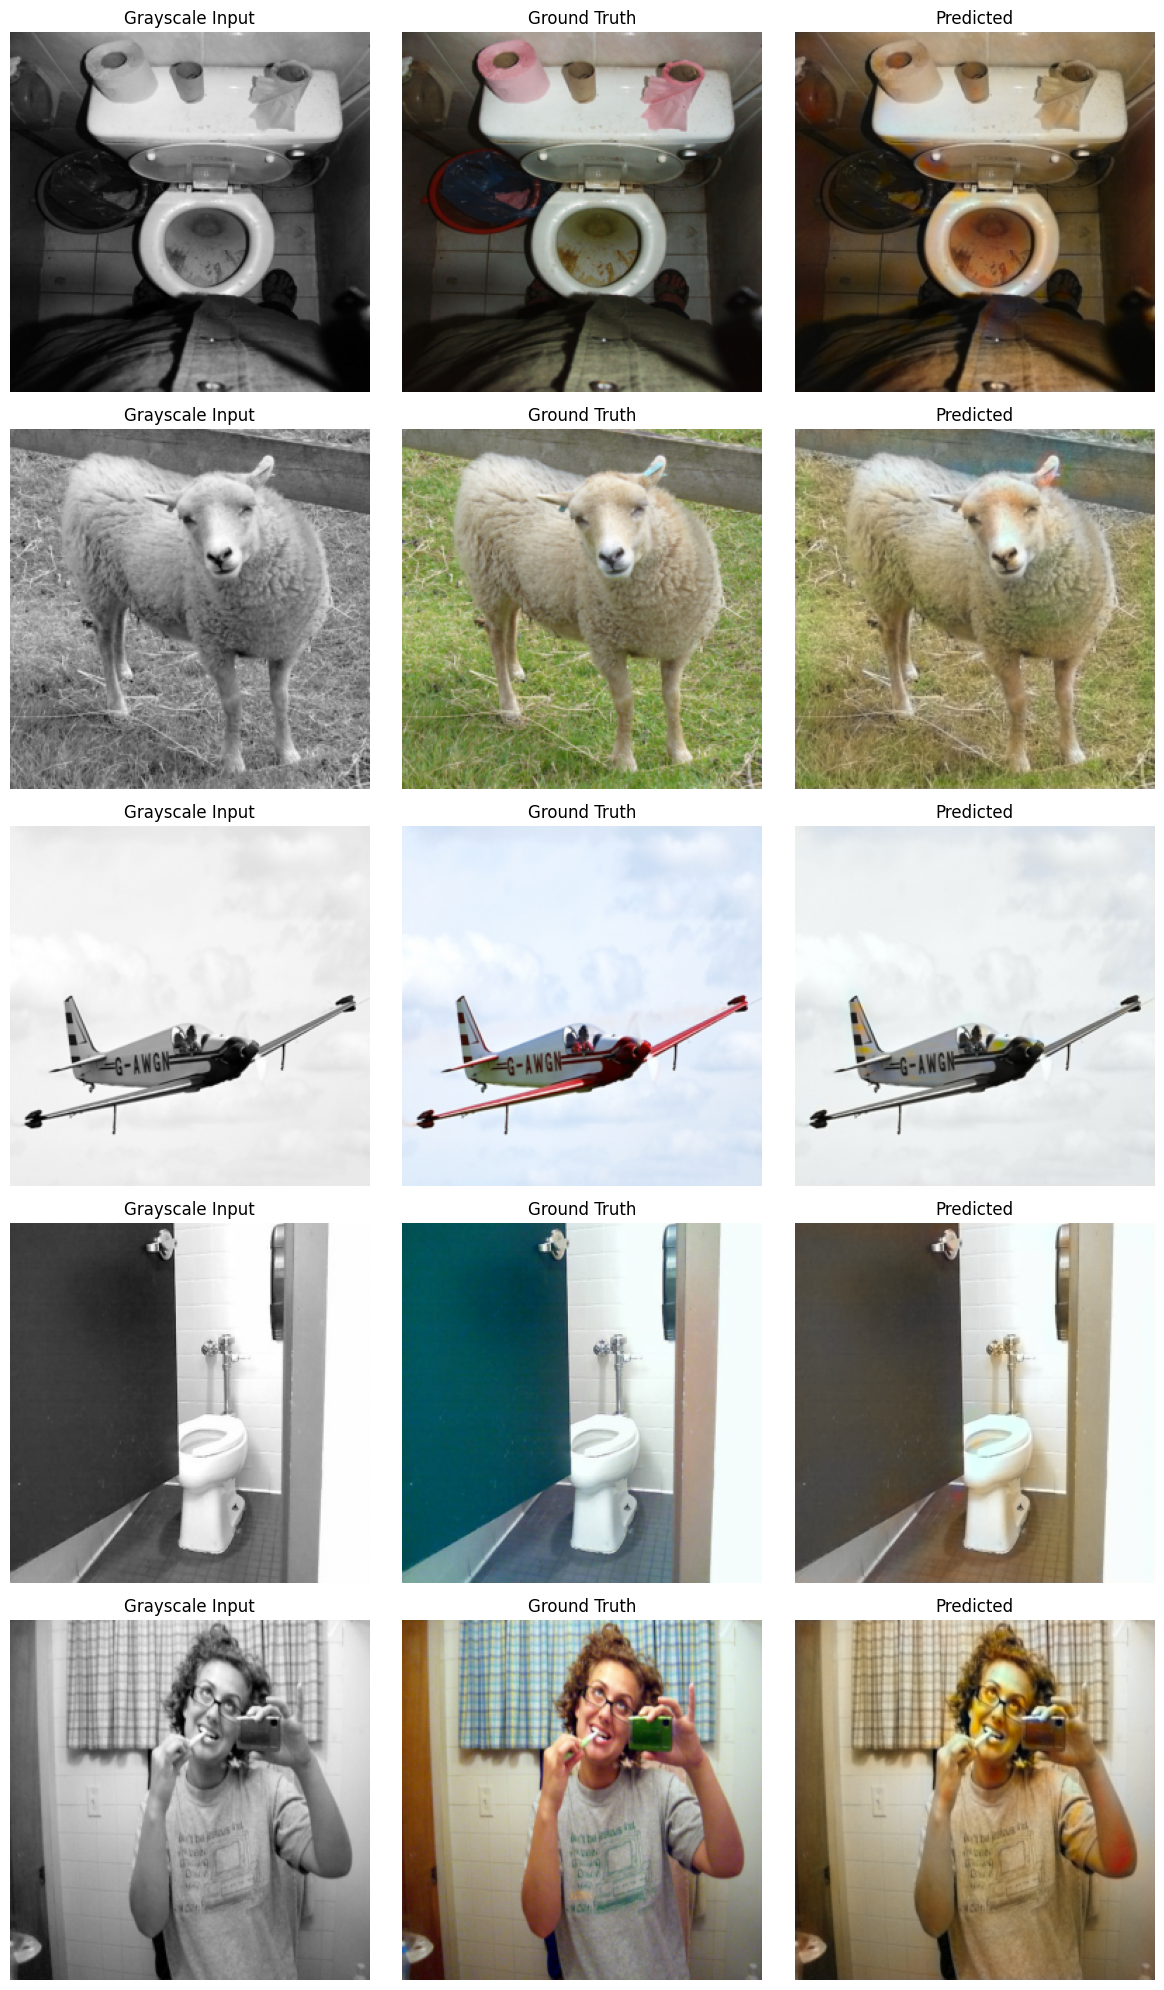

In [ ]:
def visualize_results(model, val_loader, device, num_samples=5):
    """Visualize colorization results"""
    import matplotlib.pyplot as plt

    model.eval()

    # Get a batch from validation
    L_batch, ab_batch = next(iter(val_loader))
    L_batch = L_batch[:num_samples].to(device)
    ab_batch = ab_batch[:num_samples].to(device)

    with torch.no_grad():
        ab_pred = model(L_batch)

    # Convert back to RGB for visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    for i in range(num_samples):
        # Grayscale input
        L_img = L_batch[i].cpu().numpy()[0]
        axes[i, 0].imshow(L_img, cmap='gray')
        axes[i, 0].set_title('Grayscale Input')
        axes[i, 0].axis('off')

        # Ground truth colorized
        L_real = L_batch[i].cpu().numpy()[0] * 100.0
        ab_real = ab_batch[i].cpu().numpy().transpose(1, 2, 0) * 128.0
        lab_real = np.concatenate([L_real[:, :, np.newaxis], ab_real], axis=2)
        rgb_real = color.lab2rgb(lab_real)
        axes[i, 1].imshow(rgb_real)
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Predicted colorized
        L_pred = L_batch[i].cpu().numpy()[0] * 100.0
        ab_pred_np = ab_pred[i].cpu().numpy().transpose(1, 2, 0) * 128.0
        lab_pred = np.concatenate([L_pred[:, :, np.newaxis], ab_pred_np], axis=2)
        rgb_pred = color.lab2rgb(lab_pred)
        axes[i, 2].imshow(rgb_pred)
        axes[i, 2].set_title('Predicted')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig('colorization_results.png')
    plt.show()

# Run evaluation
avg_val_l1, avg_val_ssim = evaluate_model(model, val_loader, device)

# Visualize some results
visualize_results(model, val_loader, device, num_samples=5)